In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# utilities
import re
import pickle
import nltk
nltk.download('wordnet')
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier




from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


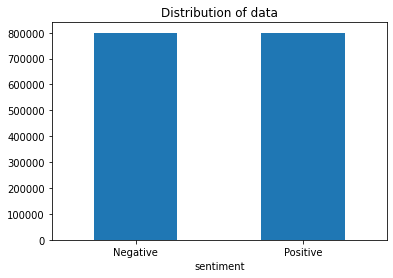

In [ ]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# previously y = (0, 4), we replace 4 with 1 and now y = (0, 1)
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
                                          
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

Let's see how our texts look like now!

In [ ]:
text[-5:]

['Just woke up. Having no school is the best feeling ever ',
 'TheWDB.com - Very cool to hear old Walt interviews!  â\x99« http://blip.fm/~8bmta',
 'Are you ready for your MoJo Makeover? Ask me for details ',
 'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
 'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H ']

In [ ]:
sentiment[-5:]


[1, 1, 1, 1, 1]

## Preprocessing elements

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
        
            if len(word)>1 and word not in stopwordlist:
              word = wordLemm.lemmatize(word)
              tweetwords += word+' '

        processedText.append(tweetwords)
        
    return processedText

#Calculating preprocessing time

In [ ]:
import time

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
# time = after preprocessing - brfore preprocessing
print(f'Time Taken: {round(time.time()-t)} seconds')


Text Preprocessing complete.
Time Taken: 155 seconds


In [ ]:
processedtext[-5:]

['woke no school best feeling ever ',
 'thewdb com cool hear old walt interview URL ',
 'ready mojo makeover ask detail ',
 'happy 38th birthday boo time tupac amaru shakur ',
 'happy charitytuesday USER USER USER ']

#Plotting out the positive words in a *Word Cloud*

Positive Words

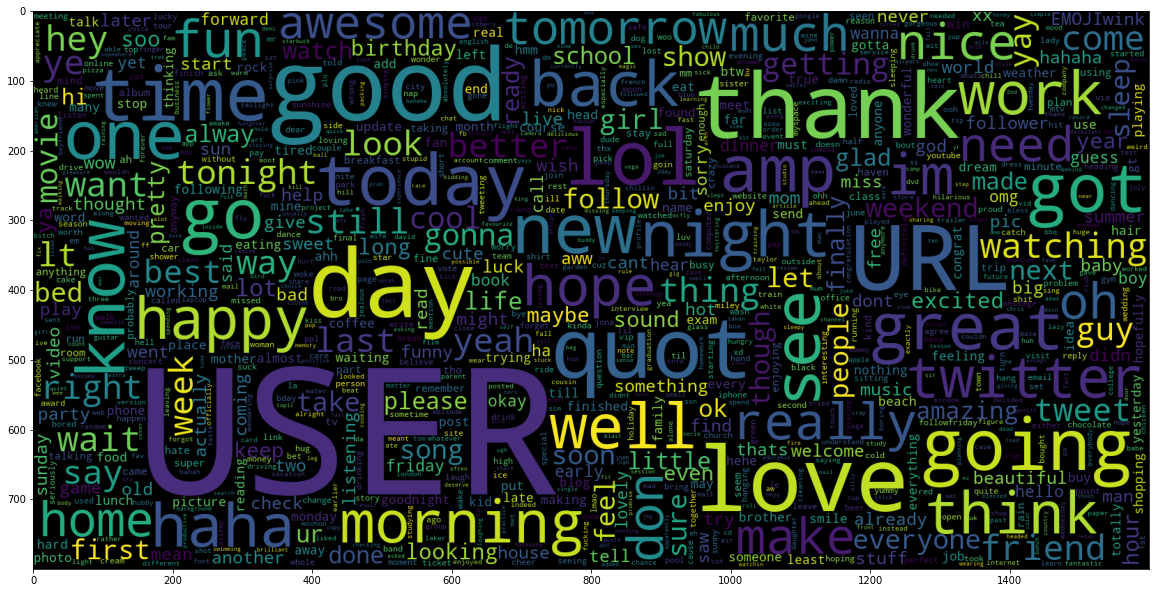

In [ ]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

Negative Words

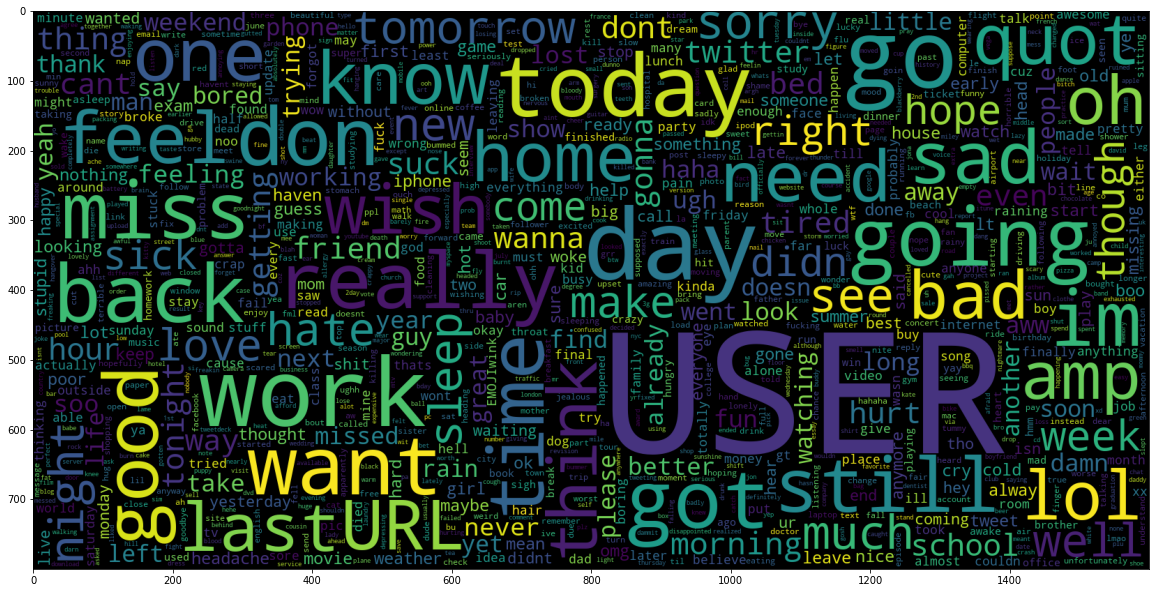

In [ ]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

## Splitting out train and test set (train set 95%, test set 5% of total dataset)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, train_size = .95,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## Looking at the train and test set now!

In [ ]:
X_train[:5]

['working double texas roadhouse ',
 'envy everyone thats not working today nice day ',
 'USER hehe thanks everyone class laughing ',
 'woot woot haha gonna go movie uncle iphone ',
 'pissed use crappy phone til get new one ']

In [ ]:
y_train[:5]

[0, 0, 1, 1, 0]

In [ ]:
X_test[:5]

['want compete want hard competition want rally want feel power coming engine want compete ',
 'seems stuck ground amarillo put ground stop flight leaving denver said update hour ',
 'pinking shear rarararrarararr babyproofing cutting stuff make stick shear random place amp forget ',
 '0ff t0 meetin hate ppl v0lunteer free time grr ',
 'reply pls ']

In [ ]:
y_test[:5]

[0, 0, 0, 0, 1]

#Now, it's the time to convert our texts into vector. To do so, we are using 'TF-IDF'

TF : Term Frequency <br>
IDF : Inverse Document Frequency <br>
*ngram_range* : how many words we treat to be extracted as a single value <br>
e.g ngram_range = (1, 2) means *very nice* can be extracted as **very** as well as **very nice** (a single value).

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
X_train[1]

<1x500000 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

#Evaluation Model Frame



In [ ]:
from sklearn.metrics import accuracy_score
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    # return accuracy_score(y_test, y_pred)

Random Forest

              precision    recall  f1-score   support

           0       0.72      0.73      0.72     39989
           1       0.72      0.71      0.72     40011

    accuracy                           0.72     80000
   macro avg       0.72      0.72      0.72     80000
weighted avg       0.72      0.72      0.72     80000



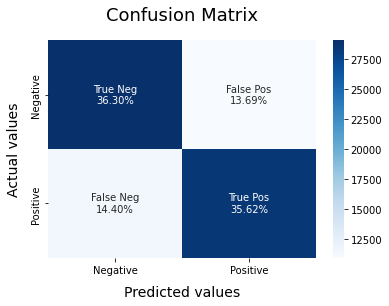

In [ ]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)
rf_acc = accuracy_score(rf.predict(X_test), y_test)

In [ ]:
rf_acc

0.719125

Linear SVC(Support Vector Classification)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.81     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



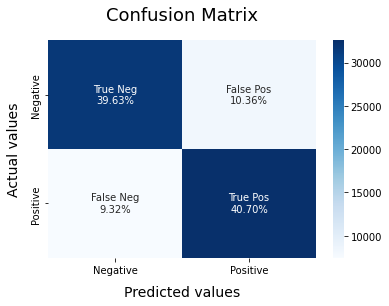

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
SVCmodel_acc = accuracy_score(SVCmodel.predict(X_test), y_test)

In [ ]:
SVCmodel_acc

0.8032625

Bernoulli Naive Bayes (BernoulliNB)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



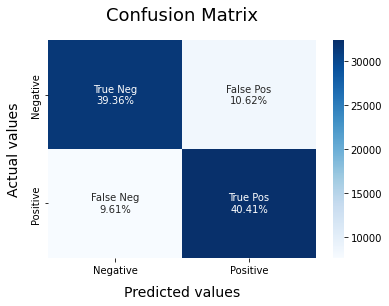

In [ ]:
# alpha (laplacian smoothing value) = 2
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
BNBmodel_acc = accuracy_score(BNBmodel.predict(X_test), y_test)

In [ ]:
BNBmodel_acc

0.7976625

Logistic Regression

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



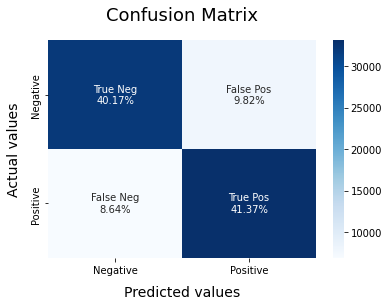

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
LRmodel_acc = accuracy_score(LRmodel.predict(X_test), y_test)

In [ ]:
LRmodel_acc

0.8154

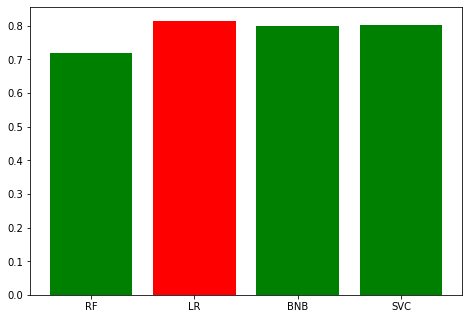

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
alogs = ['RF', 'LR', 'BNB', 'SVC']
algo_accs = [rf_acc, LRmodel_acc, BNBmodel_acc, SVCmodel_acc]
ax.bar(alogs,algo_accs, color = 'm')
plt.bar(alogs, algo_accs, color=['green', 'red', 'green', 'green'])
plt.show()

In [ ]:
ds_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/twitter_test - Sheet1.csv')

In [ ]:
ds_test

,text,sentiment
0,"and I think it has a mind of its own,like it a...",0
1,@iaintnohomo Banana will be playing later. BUT...,0
2,@koolgirl37 read my tweet below,0
3,My life http://mattf.ca/2009/06/24/yay-me/,0
4,Tried to get the mutant Fawkes to follow me bu...,0
5,Sick Spending my day laying in bed listening t...,0
6,Gmail is down?,0
7,rest in peace Farrah! So sad,0
8,@Eric_Urbane Sounds like a rival is flagging y...,0
9,has to resit exams over summer... wishes he wo...,0


In [ ]:
ds_test_txt, ds_test_sentiment = list(ds_test['text']), list(ds_test['sentiment'])

In [ ]:
ds_test_txt

["and I think it has a mind of its own,like it always ring when I'm taking a leak..jeez that makes whole thing embarrassingly musical",
 '@iaintnohomo Banana will be playing later. BUT. Shell be playing with Caro.',
 '@koolgirl37 read my tweet below',
 'My life http://mattf.ca/2009/06/24/yay-me/',
 "Tried to get the mutant Fawkes to follow me but he wouldn't it's so lonely without followers I have never had one :$",
 'Sick Spending my day laying in bed listening to @taylorswift13',
 'Gmail is down?',
 'rest in peace Farrah! So sad',
 '@Eric_Urbane Sounds like a rival is flagging your ads. Not much you can do about that though',
 'has to resit exams over summer... wishes he worked harder at first year of uni...',
 'I LOVE @Health4UandPets u guys r the best!!',
 'im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!',
 '@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.',
 'Being sick 

In [ ]:
ds_test_sentiment

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
ds_test_txt = vectoriser.transform(preprocess(ds_test_txt))

In [ ]:
from sklearn.metrics import accuracy_score
def test_model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(ds_test_txt)
    # Print the evaluation metrics for the dataset.
    print(classification_report(ds_test_sentiment, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(ds_test_sentiment, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.53      0.80      0.64        10

    accuracy                           0.55        20
   macro avg       0.57      0.55      0.52        20
weighted avg       0.57      0.55      0.52        20



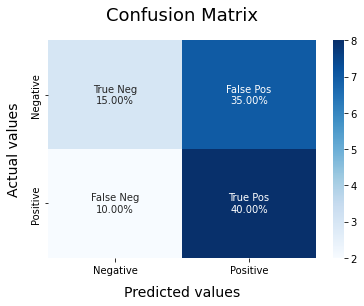

In [ ]:
test_BNBmodel = BernoulliNB(alpha = 2)
test_BNBmodel.fit(X_train, y_train)
test_model_Evaluate(test_BNBmodel)
test_BNBmodel_acc = accuracy_score(test_BNBmodel.predict(ds_test_txt), ds_test_sentiment)


In [ ]:
test_BNBmodel_acc

0.55

In [ ]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []


    # map the text with the sentiment
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df



if __name__=="__main__":
    # Loading the models.
    # vectoriser, LRmodel = load_models()
    txt = []
    inp = input()
    txt.append(inp)
    # Text to classify should be in a list.
    # text = ["You are cool",
    #         "You are not good.",
    #         "You are becoming good and healthy",
    #         "It is cold and snowy in winter"]
  
    df = predict(vectoriser, LRmodel, txt)
    print(df)

i am a happy boy
               text sentiment
0  i am a happy boy  Positive
